In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/AI_Project/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!ls

drive  sample_data


In [4]:
#!kaggle datasets download -d nitinsss/fashion-dataset-with-over-15000-labelled-images
!kaggle datasets download -d nitinsss/fashion-dataset-with-over-15000-labelled-images -p /content/drive/MyDrive/AI_Project

fashion-dataset-with-over-15000-labelled-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!ls

drive  sample_data


In [6]:
#!unzip fashion-dataset-with-over-15000-labelled-images.zip
!unzip /content/drive/MyDrive/AI_Project/fashion-dataset-with-over-15000-labelled-images.zip -d /content/drive/MyDrive/AI_Project
!ls /content/drive/MyDrive/AI_Project

Archive:  /content/drive/MyDrive/AI_Project/fashion-dataset-with-over-15000-labelled-images.zip
replace /content/drive/MyDrive/AI_Project/dress.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/drive/MyDrive/AI_Project/dress.csv  
dress.csv  fashion-dataset-with-over-15000-labelled-images.zip	kaggle.json


In [7]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/AI_Project/dress.csv',on_bad_lines='skip')

In [8]:
df.shape

(15702, 4)

In [9]:
df.head
df.columns

Index(['_unit_id', 'category', 'category:confidence', 'image_url'], dtype='object')

In [10]:
df['category'].unique()

array(['ikat', 'plain', 'polka dot', 'geometry', 'floral', 'squares',
       'scales', 'animal', 'OTHER', 'stripes', 'tribal', 'houndstooth',
       'cartoon', 'chevron', 'stars', 'letter_numb', 'skull'],
      dtype=object)

In [11]:
df['category'].nunique()


17

In [12]:
df= df[(df['category']!='OTHER')&(df['category']!='cartoon')&(df['category']!='tribal')&(df['category']!='houndstooth')]
df.shape

(14355, 4)

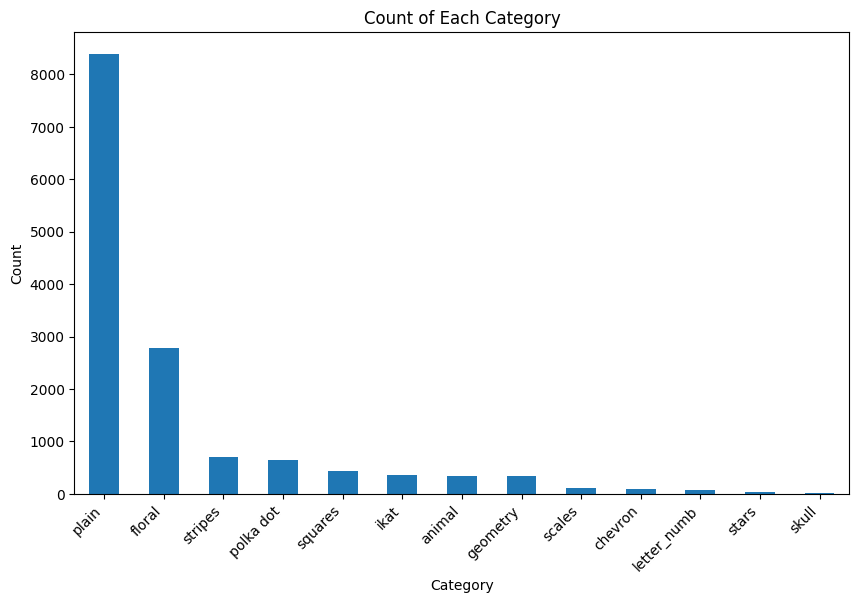

In [13]:
import matplotlib.pyplot as plt
category_counts = df['category'].value_counts()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Count of Each Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


In [14]:
import os
import requests
import numpy as np
import cv2
import zipfile
from io import BytesIO
from PIL import Image
from multiprocessing import Pool

def process_image(image_np):
    # Read the numpy arrays as color images in OpenCV
    image_bgr = cv2.imdecode(image_np, cv2.IMREAD_COLOR)

    # Convert to HSV for creating a mask
    image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

    # Create a mask that detects the red rectangular tags present in each image
    mask = cv2.inRange(image_hsv, (0, 255, 255), (0, 255, 255))

    # Get the coordinates of the red rectangle in the image,
    # But take entire image if mask fails to detect the red rectangle
    if len(np.where(mask != 0)[0]) != 0:
        y1 = min(np.where(mask != 0)[0])
        y2 = max(np.where(mask != 0)[0])
    else:
        y1 = 0
        y2 = len(mask)

    if len(np.where(mask != 0)[1]) != 0:
        x1 = min(np.where(mask != 0)[1])
        x2 = max(np.where(mask != 0)[1])
    else:
        x1 = 0
        x2 = len(mask[0])

    # Crop the image along those coordinates
    image_cropped = image_bgr[y1:y2, x1:x2]
    image_resized = cv2.resize(image_cropped, (70, 70))
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image_rgb)
    return image

    '''# Crop the image along those coordinates
    image_cropped = image_bgr[y1:y2, x1:x2]
    image_resized = cv2.resize(image_cropped, (70, 70))
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    image=Image.fromarray(image_rgb)
    return image'''

def download_image_and_save(row):
    image_url = row['image_url']
    response = requests.get(image_url)

    if response.status_code == 200:
        image_np = np.asarray(bytearray(response.content), dtype=np.uint8)
        cropped_image = process_image(image_np)

        # Save the preprocessed image directly into the in-memory zip file
        image_bytes = BytesIO()
        cropped_image.save(image_bytes, format='JPEG')
        return image_bytes.getvalue(), f"{row['category']}/{row['_unit_id']}.jpg"
    else:
        print(f"Failed to download image from URL: {image_url}")
        return None, None

def download_images_in_batch(batch_df):
    images_to_zip = []
    with Pool(processes=os.cpu_count()) as pool:
        results = pool.map(download_image_and_save, [row for _, row in batch_df.iterrows()])

    for result in results:
        if result[0] is not None:
            image_bytes, zip_path = result
            images_to_zip.append((image_bytes, zip_path))

    return images_to_zip



In [ ]:
# Define output zip file name
zip_filename = 'drive/MyDrive/images_2.zip'
batch_size = 100

# Create a zip file in-memory
i=1
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for batch_idx in range(0, len(df), batch_size):
        batch_df = df.iloc[batch_idx:batch_idx + batch_size]
        images_to_zip = download_images_in_batch(batch_df)
        print(f'batch{i}')
        i+=1
        for image_bytes, zip_path in images_to_zip:
            zipf.writestr(zip_path, image_bytes)

print("All images zipped successfully.")